# **An introduction to bivariate signal processing: polarization, quaternions and geometric representations**
# *Eusipco Tutorial, Lyon 2024*


---



---



# **Notebook II**: Spectral analysis and filtering of bivariate signals
#### (Part of the material presented here is from [Bispy tutorial](https://bispy.readthedocs.io/en/latest/tutorials/index.html))
---
---
**Related publications**
- "*Spectral analysis of stationary random bivariate signals*", J. Flamant, N. Le Bihan and P. Chainais, IEEE Transactions on Signal Processing (TSP), vol. 65, num. 23, pp. 6135-6145, 2017.
[link to the paper](https://hal.science/hal-01655097/document)

- "*A Complete Framework for Linear Filtering of Bivariate Signals*", J. Flamant, P. Chainais and N. Le Bihan, IEEE Transactions on Signal Processing (TSP), vol. 66, num. 17, pp.4541-4552, 2018.
[link to the paper](https://arxiv.org/pdf/1802.02469)

---
---

## Set up/imports


First install the ``bispy-polar`` package from PyPi. It will install the necessary dependencies. 

In [ ]:
!pip install bispy-polar

Second, import the BiSPy package and other relevant packages

In [5]:
import bispy as bsp
import numpy as np
import matplotlib.pyplot as plt
import quaternion
import scipy.signal as sg

We are good to go now.

## Road map

**What we will be doing in this notebook** :

1. Spectral synthesis of a bivariate signal
2. Non parametric spectral estimation: periodogram and multitaper estimators
3. Decomposition into unpolarized and polarized parts



# 1. Spectral synthesis of a bivariate signal

In this section, we will generate a random second-order stationary bivariate signal with prescribed spectral properties, i.e. we fix the quaternion PSD of the bivariate signal.


TODO: write the math of it

First, let us define the quaternion PSD of the target signal. For simplicity, we consider a narrow-band signal with spectrally-constant polarization properties; we also consider partial polarization.

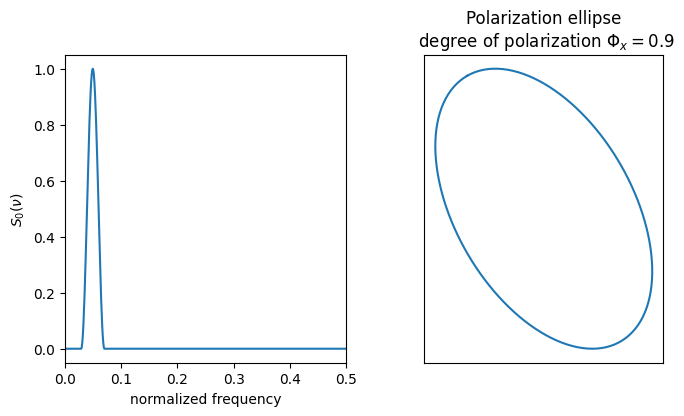

In [6]:
# target parameters

N = 1024 # length of the signal to be simulated
t = np.arange(N)
# polarization parameters
thetax = 2*np.pi/3
chix = np.pi/6
mu_x = np.quaternion(0, np.sin(2*chix), np.cos(2*thetax)*np.cos(2*chix), np.sin(2*thetax)*np.cos(2*chix)) # polarization axis
phi_x = 0.9 # degree of polarization, between 0 and 1

# spectral response S_0(\nu)
S_0 = np.zeros(N)
nu0 = 0.05 # central frequency in normalized freq
bw = 0.02# half bandwidth in normalized freq

N0 = int(nu0*N)
BW = int(bw*N)
S_0[N0-BW:N0+BW+1] = bsp.utils.windows.hanning(2*BW+1)


# display spectral response and corresponding polarization ellipse
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))

ax[0].plot(np.linspace(0, 1, N), S_0)
ax[0].set_xlim(0, 0.5)
ax[0].set_xlabel('normalized frequency');
ax[0].set_ylabel(r'$S_0(\nu)$');

__, ell = bsp.utils.polarizationEllipse(thetax, chix)
ax[1].plot(ell.real, ell.imag)
ax[1].set_aspect('equal')
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title('Polarization ellipse\n degree of polarization '+r'$\Phi_x = $'+str(phi_x));

Now we construct the Hermitian filter such that, when excited by unpolarized white noise, the output quaternion PSD is that of our target signal.

In [7]:
# filter parameters

# polarizing power
eta = (1 - np.sqrt(1-phi_x**2))/phi_x
# polarization axis of the filter
mu = mu_x.copy()

# define the gain (with possible oversampling to avoid border effects)
over = 4
M = over*N # this will be the length of the simulation

K_u = np.sqrt(S_0/(1+eta**2)) # see formula in paper
K = sg.resample(K_u, M)

# construct the filter
hf = bsp.filters.HermitianFilter(M, K, eta, mu)

We are now ready to simulate the signal. Let us generate an unpolarized white noise sequence and then feed it as input of our carefully designed filter.  

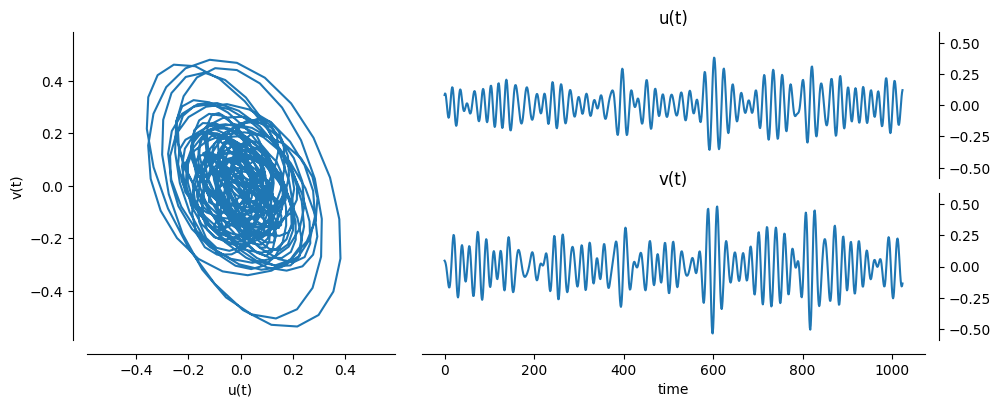

In [8]:
np.random.seed(12303) # fix the seed for reproducibility)
w = bsp.signals.bivariatewhiteNoise(M, 1, P=0)

x = hf.output(w)[:N] # keep only first N samples

# lets display
fig, ax = bsp.utils.visual.plot2D(t,x)

Now, we are going to check that this signal has the desired quaternion PSD using nonparametric spectral estimation techniques

# 2. Non parametric spectral estimation: periodogram and multitaper estimators

The simplest quaternion PSD estimator is the quaternion periodogram. Given a discrete bivariate sequence $x[1], ..., x[N]$, it is defined as:

$$\Gamma_{xx}^{p}(\nu) = \frac{\Delta_t}{N}\left\vert\sum_{n = 1}^{N} x[n]e^{-j2\pi\nu n\Delta_t}\right\vert^2 +
      \frac{\Delta_t}{N}\left(\sum_{n = 1}^{N} x[n]e^{-j\pi\nu n\Delta_t}\right)j\left(\overline{\sum_{n = 1}^{N} x[n]e^{-j2\pi\nu n\Delta_t}}\right)
$$

The BiSPy command is ``bispy.spectral.Periodogram``.

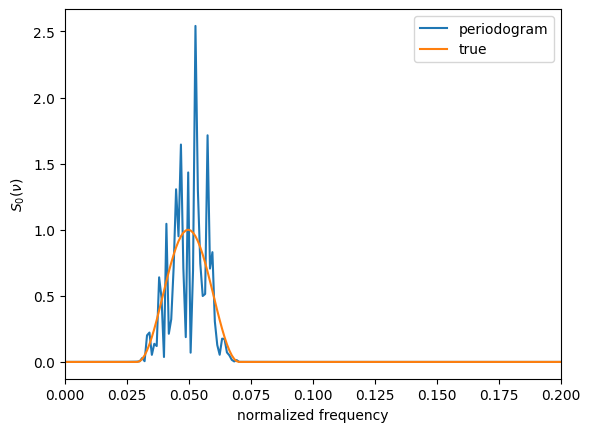

In [9]:
per = bsp.spectral.Periodogram(t, x)

# let us first have a look at S0

plt.plot(per.f[:N//2], per.S0[:N//2], label='periodogram')
plt.plot(per.f[:N//2], S_0[:N//2], label='true')
plt.xlabel('normalized frequency')
plt.ylabel(r'$S_0(\nu)$')
plt.xlim(0, 0.2)
plt.legend();

/Users/julienflamant/Documents/Collabs/Ricochet/Gitlab/2024_eusipco_tutorial_bivariate_signal_processing/.venv/lib/python3.11/site-packages/bispy/spectral.py:415: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


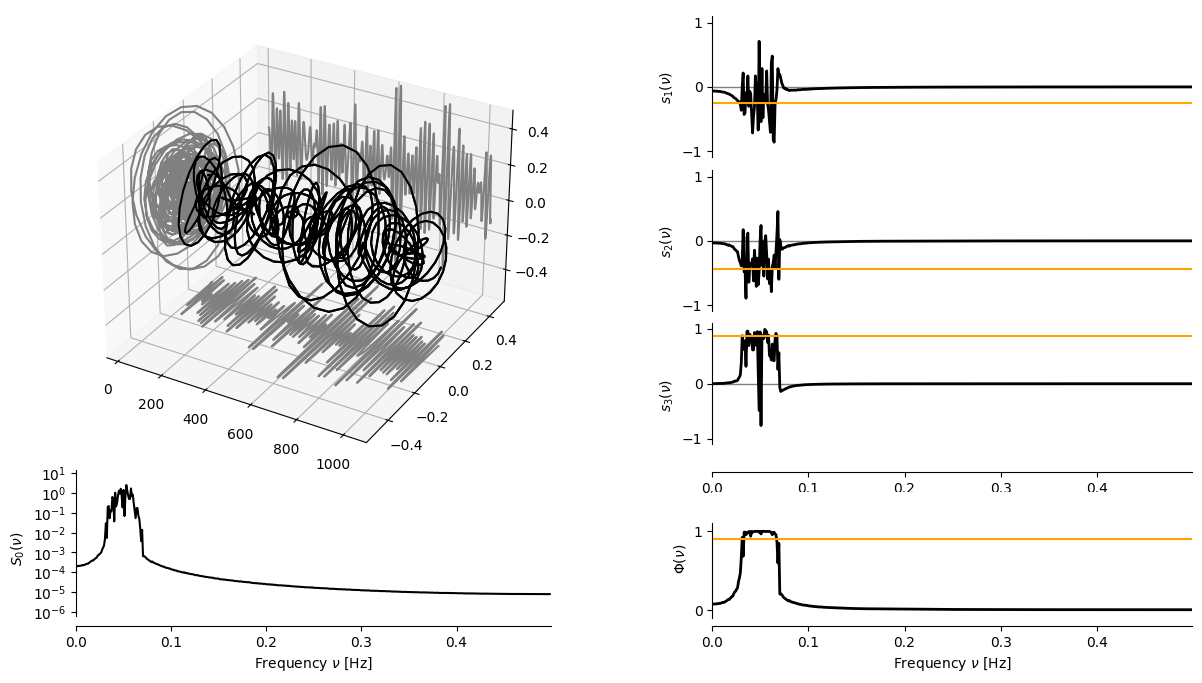

In [10]:
# display all parameters
per.normalize(tol=1e-3) # to populate normalized Stokes attributes of per
fig, ax = per.plot();

# display true values
ax[2].axhline(np.cos(2*thetax)*np.cos(2*chix), color='orange')
ax[3].axhline(np.sin(2*thetax)*np.cos(2*chix), color='orange')
ax[4].axhline(np.sin(2*chix), color='orange')
ax[5].axhline(phi_x, color='orange');

We immediatly observe that the estimated degree of polarization is 1. This is a feature of periodogram estimators. To properly estimate the degree of polarization, we either need:
- different realizations of the same process (e.g. independent observations, or by considering different segments of the signal aka Bartlett/Welch method)
- use a multitaper approach, which relies on a sequence of orthonormomal tapers

We'll look at the second option, using DPSS sequences. These are controlled by a bandwidth parameter, which directly controls the number of sequences used.

The BiSPy class for this is ``bispy.spectral.Multitaper``.

Number of data tapers: 9


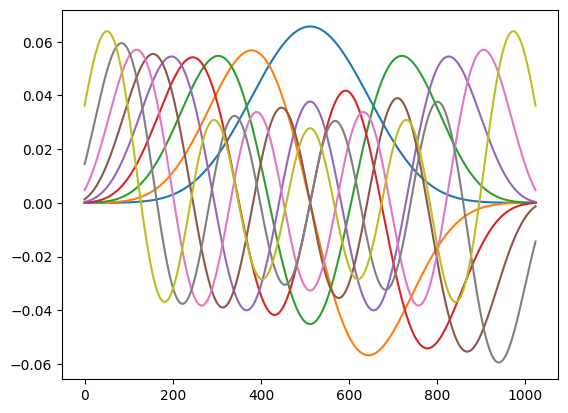

In [11]:
multi = bsp.spectral.Multitaper(t, x, bw=5)
# display
plt.plot(multi.dpss);

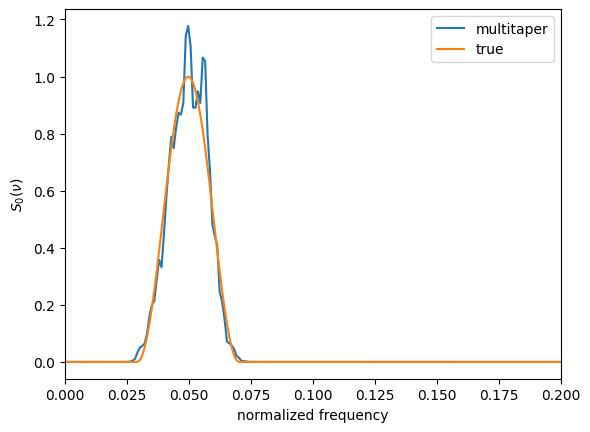

In [12]:
# let us first have a look at S0

plt.plot(multi.f[:N//2], multi.S0[:N//2], label='multitaper')
plt.plot(multi.f[:N//2], S_0[:N//2], label='true')
plt.xlabel('normalized frequency')
plt.ylabel(r'$S_0(\nu)$')
plt.xlim(0, 0.2)
plt.legend();

/Users/julienflamant/Documents/Collabs/Ricochet/Gitlab/2024_eusipco_tutorial_bivariate_signal_processing/.venv/lib/python3.11/site-packages/bispy/spectral.py:617: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


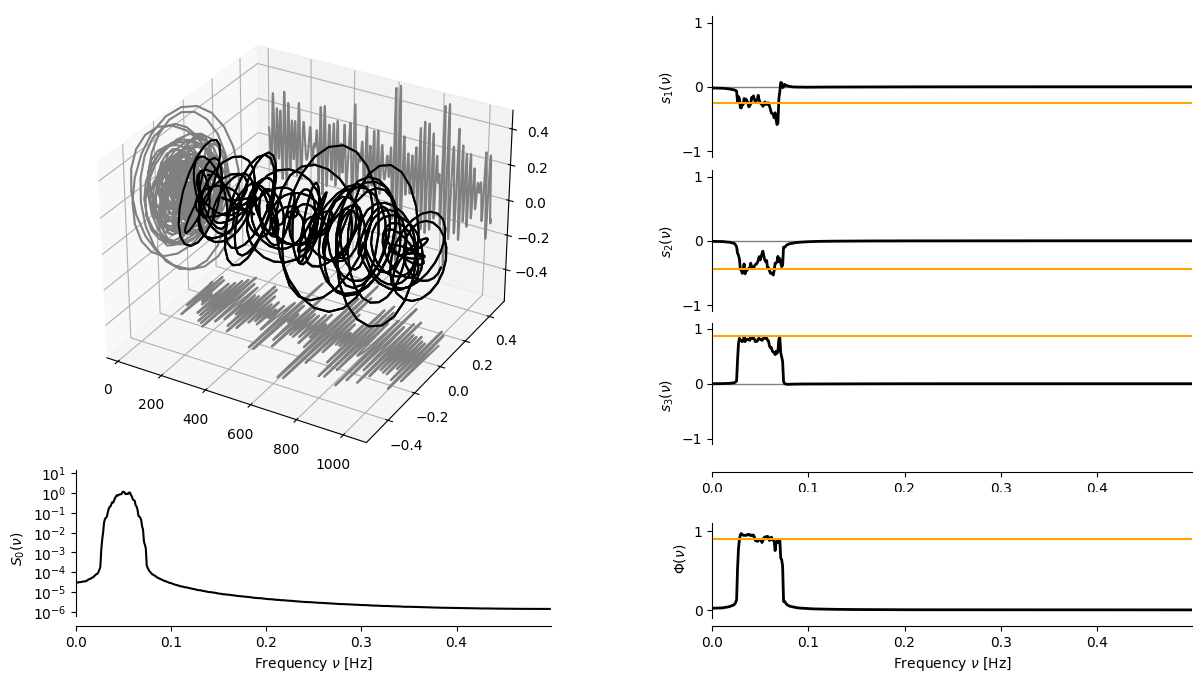

In [13]:
multi.normalize(tol=1e-3) # to populate normalized Stokes attributes
fig, ax = multi.plot();
ax[2].axhline(np.cos(2*thetax)*np.cos(2*chix), color='orange')
ax[3].axhline(np.sin(2*thetax)*np.cos(2*chix), color='orange')
ax[4].axhline(np.sin(2*chix), color='orange')
ax[5].axhline(phi_x, color='orange');


For more details on what can be done with spectral analysis tools in BiSPy, see [this tutorial](https://bispy.readthedocs.io/en/latest/tutorials/spectralanalysis.html).

# 3. Decomposition into unpolarized and polarized parts

In this last section, we will decompose our simulated signal into its polarized and unpolarized parts thanks to a well-designed Hermitian filter.

In [14]:
# construct the filter

mu = mu_x.copy()
eta = 1
K = 1-phi_x/(phi_x+ 1 - np.sqrt(1-phi_x**2))

h_up = bsp.filters.HermitianFilter(N, K, eta, mu)

In [15]:
x_p = h_up.output(x) # polarized part
x_u = x - x_p # unpolarized part

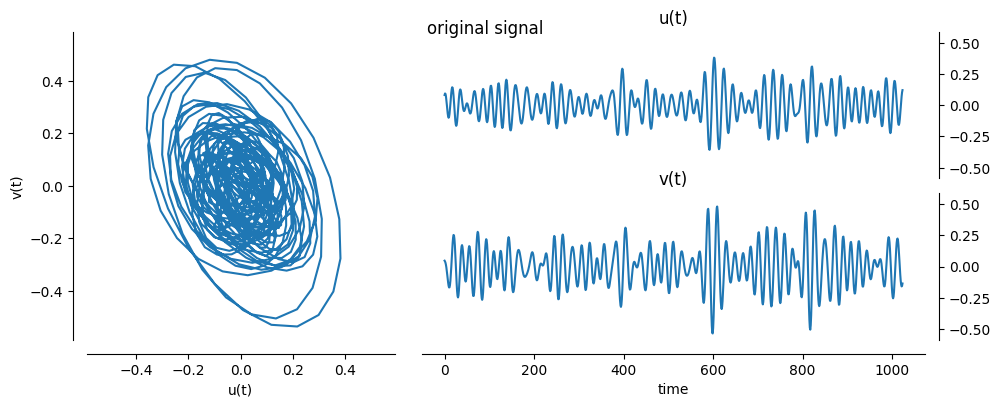

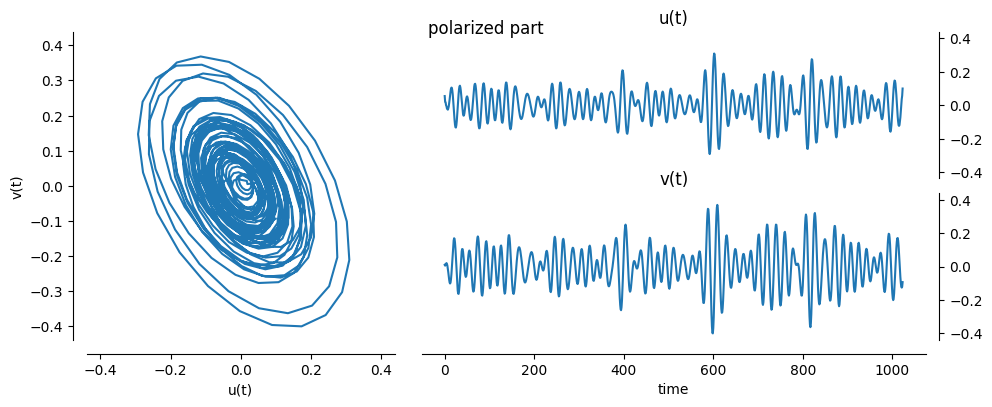

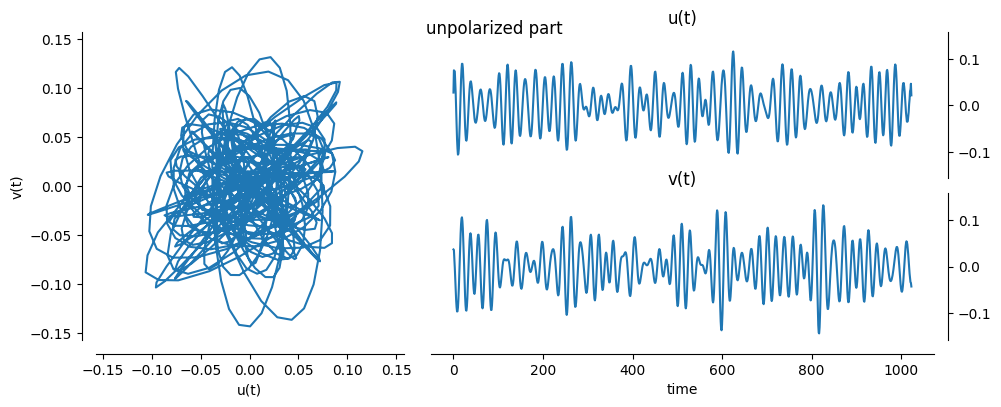

In [16]:
# plot the signal, its polarized part
fig, ax = bsp.utils.visual.plot2D(t, x);
fig.suptitle('original signal');

fig, ax = bsp.utils.visual.plot2D(t, x_p);
fig.suptitle('polarized part');

fig, ax = bsp.utils.visual.plot2D(t, x_u);
fig.suptitle('unpolarized part');